In [1]:
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, KWTA, ActivityBaseHomeostasis, VoltageBaseHomeostasis
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder

from models.activity import ActivityRecorder
from models.dendrites import LateralDendriticInput2D, LateralInhibitionDendriticInput
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap
from utils.formatter import pretty_format_dict
from utils.plots import add_colorized_raset_plot


In [2]:
INSTANCE_DURATION = 20
SLEEP = 10
dataset = load_data(directory='dataset', resize_width=3, resize_height=3, img_formats=(".png",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=2)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

# Activity-base homeostasis

In [8]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset.shape[1],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            ActivityBaseHomeostasis(activity_rate=0.5*INSTANCE_DURATION,
                                    window_size=2*(INSTANCE_DURATION + SLEEP),
                                    updating_rate=1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=50.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True, False, False,  True,  True, False,  True, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True, False,  True,  True, False, False,  True, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True, False, False,  True,  True, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True,  Tr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


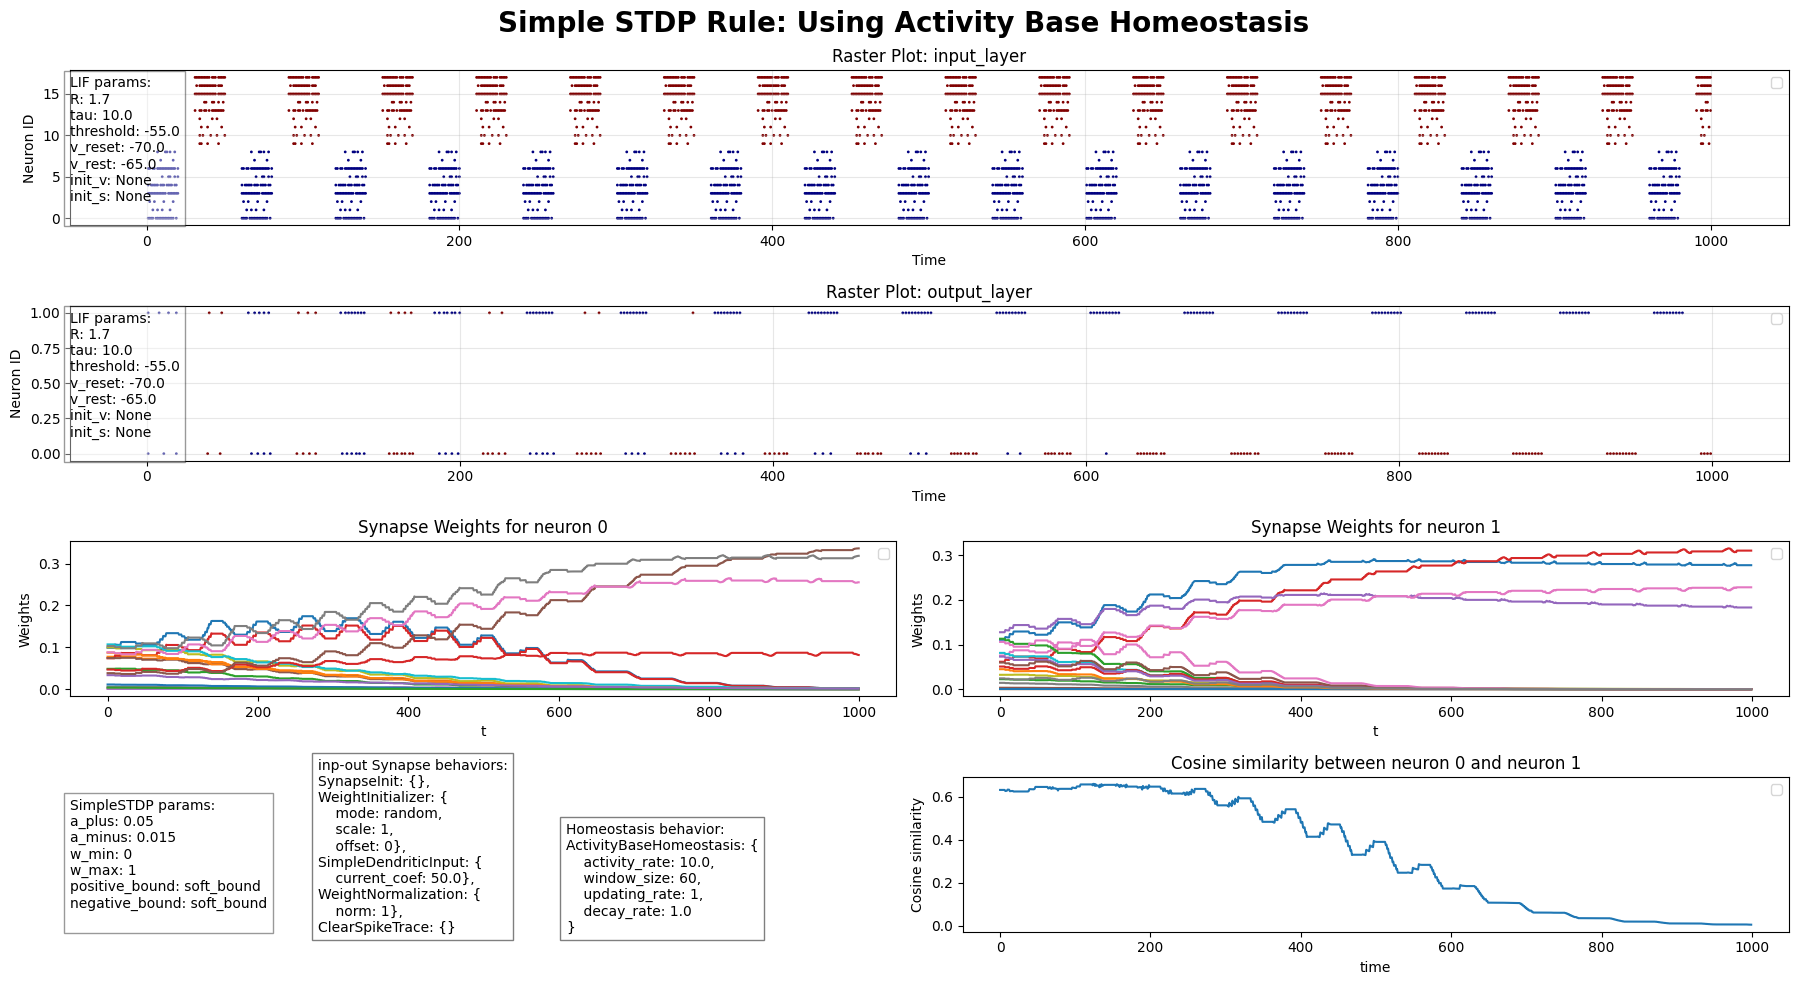

In [10]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
# input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
# output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using Activity Base Homeostasis", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-homeostasis.pdf")
plt.show()

## Lateral Inhibition + KWTA + Homeostasis

In [3]:
INSTANCE_DURATION = 100
SLEEP = 10
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [25]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1),
            ActivityBaseHomeostasis(activity_rate=0.5*INSTANCE_DURATION,
                                    window_size=(INSTANCE_DURATION + SLEEP),
                                    updating_rate=0.25,
                                    decay_rate=1
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


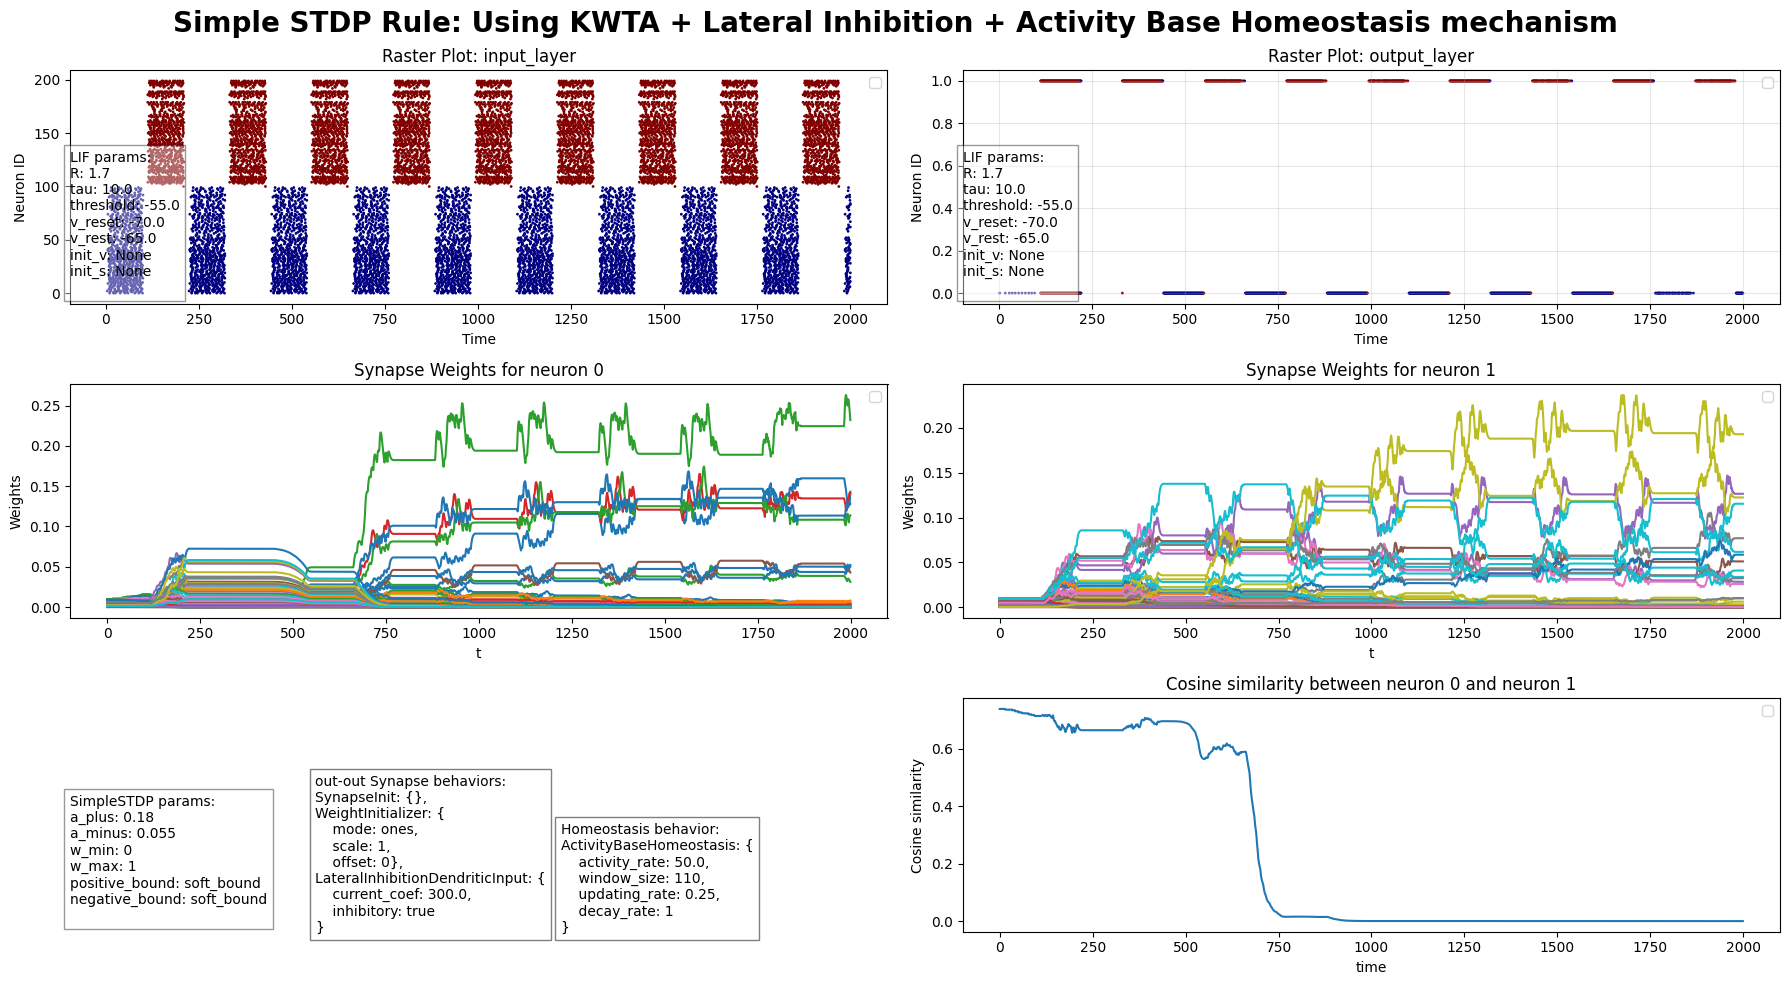

In [28]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using KWTA + Lateral Inhibition + Activity Base Homeostasis mechanism", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibtion-homeostasis.pdf")
plt.show()

# Increase number of patterns

In [22]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/5pic', resize_width=7, resize_height=7, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=2)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [28]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1),
            ActivityBaseHomeostasis(activity_rate=0.15*INSTANCE_DURATION,
                                    window_size=(INSTANCE_DURATION + SLEEP),
                                    updating_rate=0.1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=75.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(250)|2 groups, Synapses: tensor(1250)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](245){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


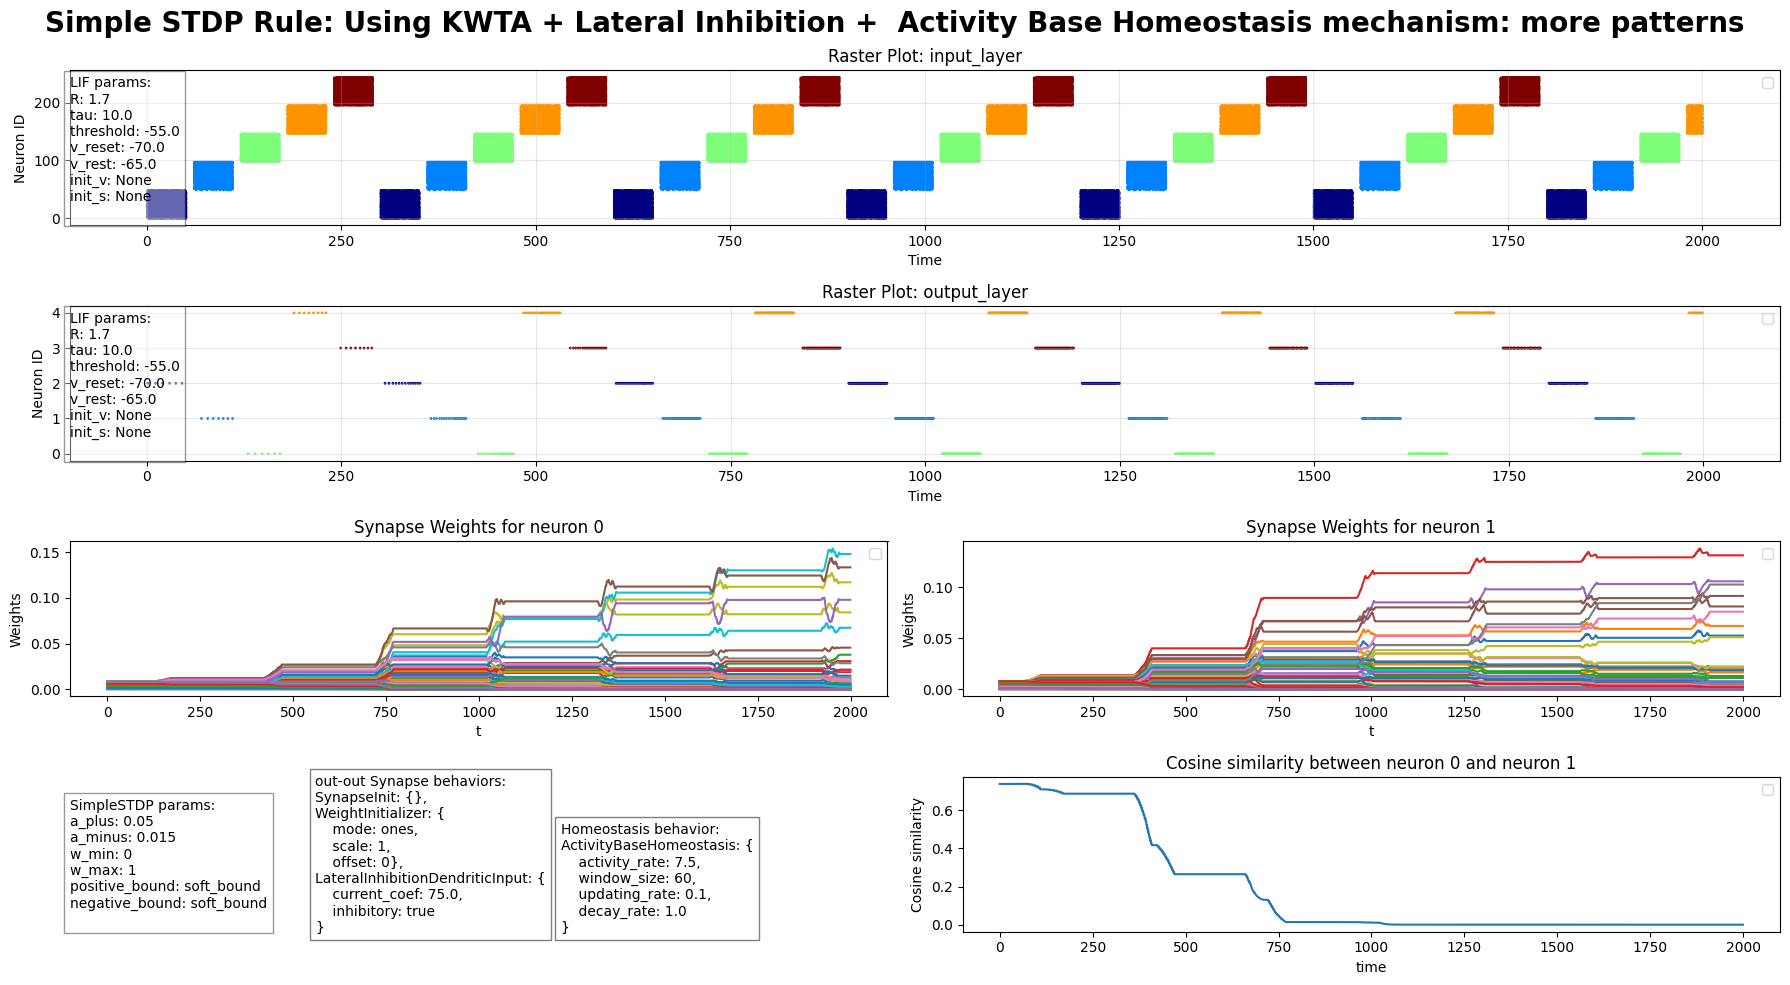

In [30]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using KWTA + Lateral Inhibition +  Activity Base Homeostasis mechanism: more patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibtion-homeostasis-5-patterns.pdf")
plt.show()

### Even more patterns

In [34]:
INSTANCE_DURATION = 25
SLEEP = 10
dataset = load_data(directory='dataset/10pic', resize_width=5, resize_height=5, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=5)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [36]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1),
            ActivityBaseHomeostasis(activity_rate=0.1*INSTANCE_DURATION,
                                    window_size=(INSTANCE_DURATION + SLEEP),
                                    updating_rate=0.1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=75.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(260)|2 groups, Synapses: tensor(2600)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](250){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


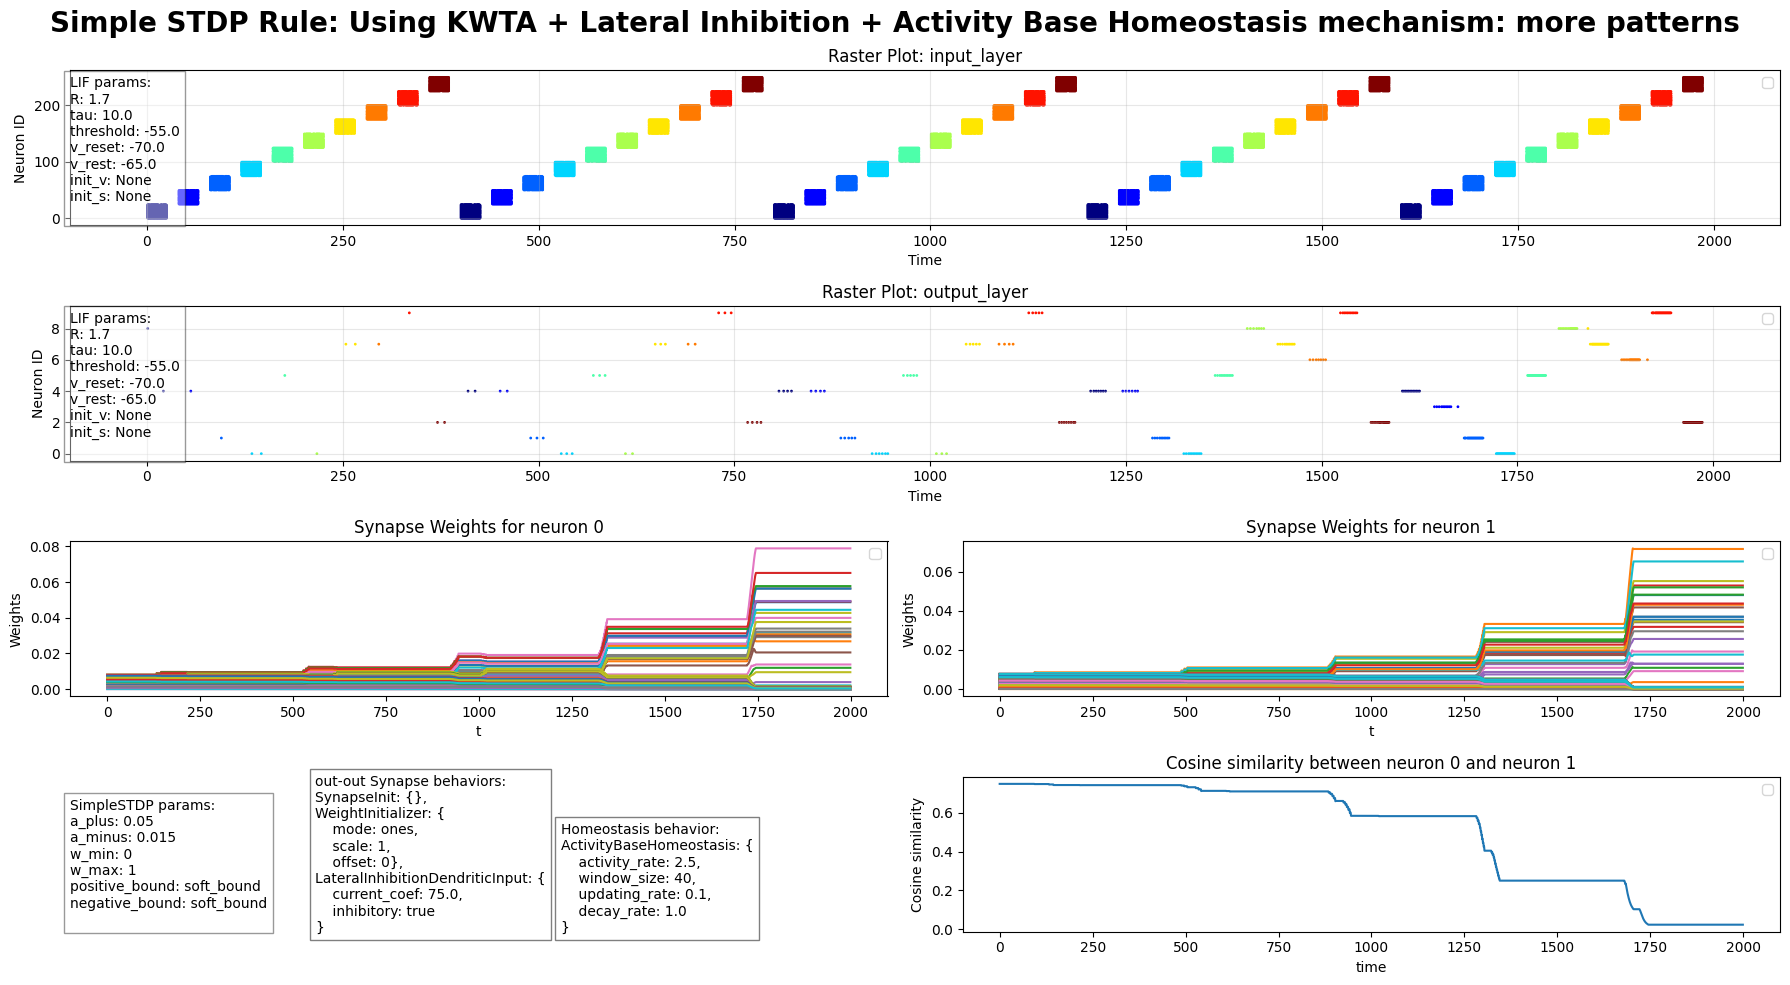

In [38]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using KWTA + Lateral Inhibition + Activity Base Homeostasis mechanism: more patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibtion-homeostasis-10-patterns.pdf")
plt.show()

# Voltage-base Homeostasis

In [40]:
INSTANCE_DURATION = 20
SLEEP = 10
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0., epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=2)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [48]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            VoltageBaseHomeostasis(target_voltage=-60,
                                   max_ta=30,
                                   min_ta=-100,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=50.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False, False,  True,  True,  True, False,  True, False,
          False, False, False, False, False, False, False, False],
         [ True, False, False,  True, False, False,  True, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True, False, False,  True,  True, False,  True, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True, Fal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


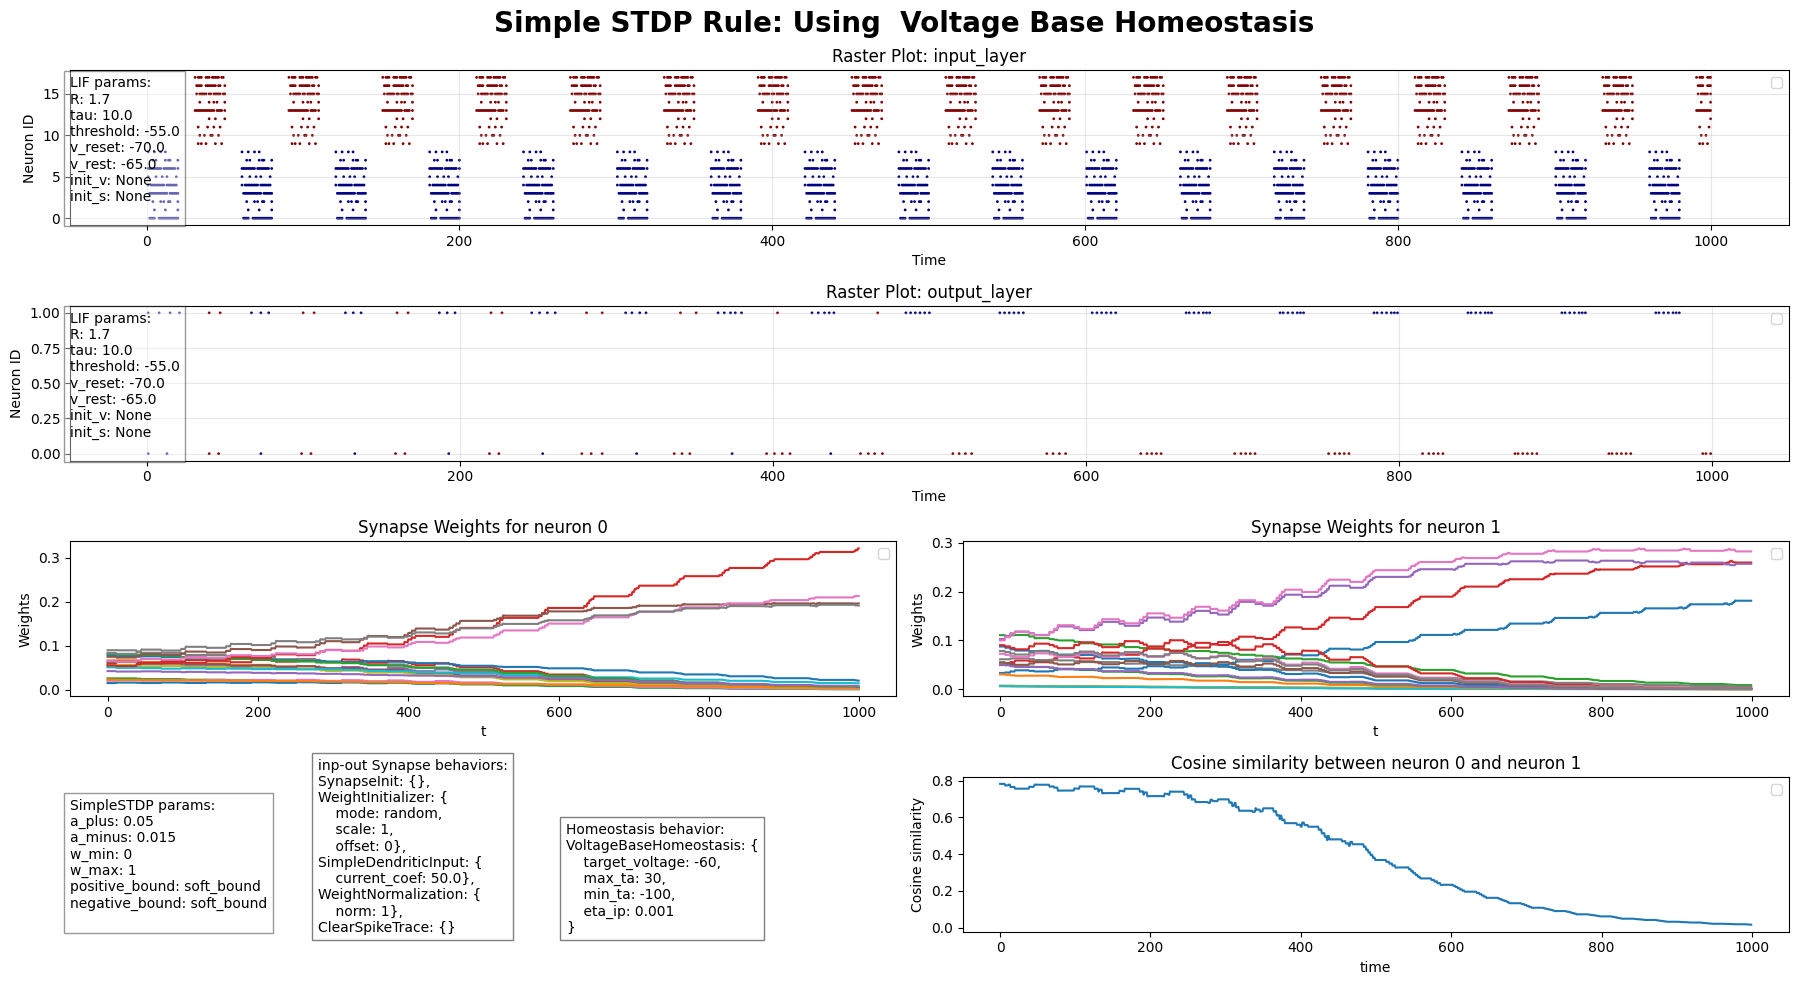

In [50]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using  Voltage Base Homeostasis", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-voltage-homeostasis.pdf")
plt.show()

## KWTA + Lateral Inhibition + Voltage Base Homeostasis

In [3]:
INSTANCE_DURATION = 100
SLEEP = 10
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [26]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset.shape[1],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            VoltageBaseHomeostasis(
                                    target_voltage=-60,
                                   max_ta=-30,
                                   min_ta=-100,
                                   eta_ip=0.00005
                                    ),
            KWTA(k=1),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


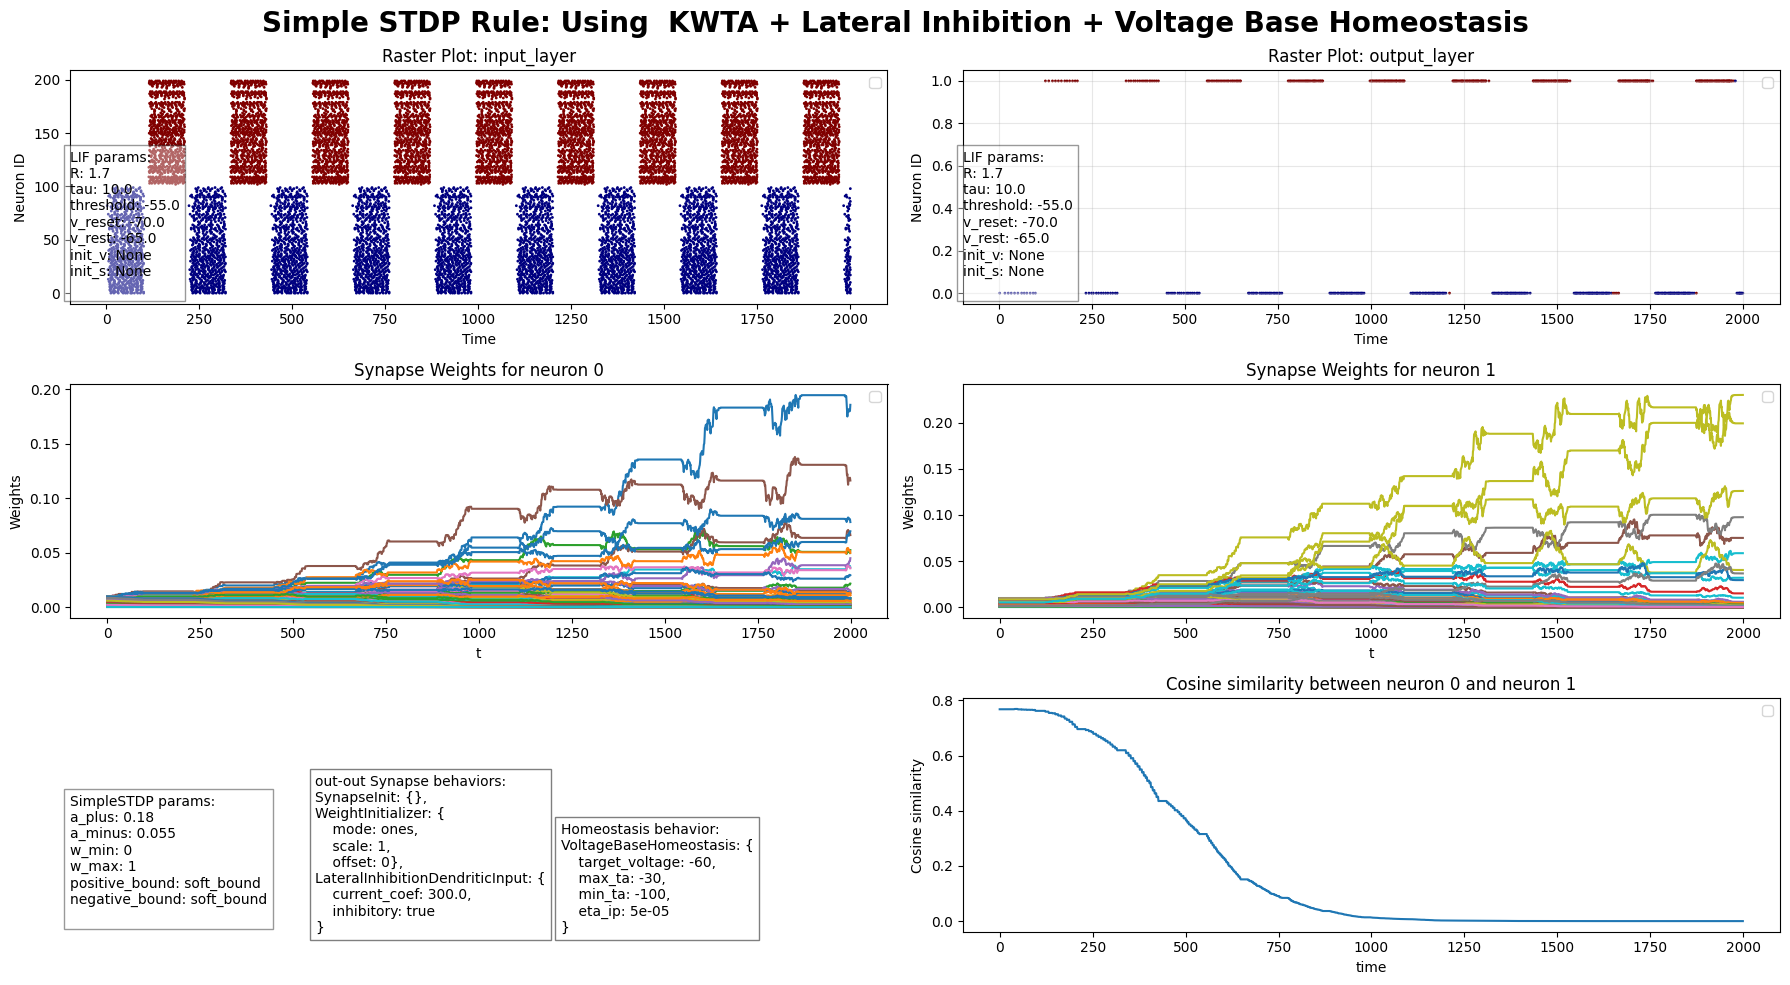

In [28]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using  KWTA + Lateral Inhibition + Voltage Base Homeostasis", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibition-voltage-homeostasis.pdf")
plt.show()

In [230]:
# fig = plt.figure(figsize=(18, 5))
#
# ax1 = fig.add_subplot(1, 1, 1)  # 3 rows, 1 column, first plot
# output_layer.add_membrane_potential_plot(ax1, neuron_model_class=LIF, recorder_behavior_class=Recorder)
# fig.suptitle("Voltages of output layers", fontsize=20, fontweight='bold')
# plt.tight_layout()
# plt.show()

## Different number of neurons with patterns

### a) number of patterns are more than output neurons

In [55]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/5pic', resize_width=7, resize_height=7, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=2)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [58]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=3,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1),
            ActivityBaseHomeostasis(activity_rate=0.15*INSTANCE_DURATION,
                                    window_size=(INSTANCE_DURATION + SLEEP),
                                    updating_rate=0.1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=75.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(248)|2 groups, Synapses: tensor(744)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](245){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


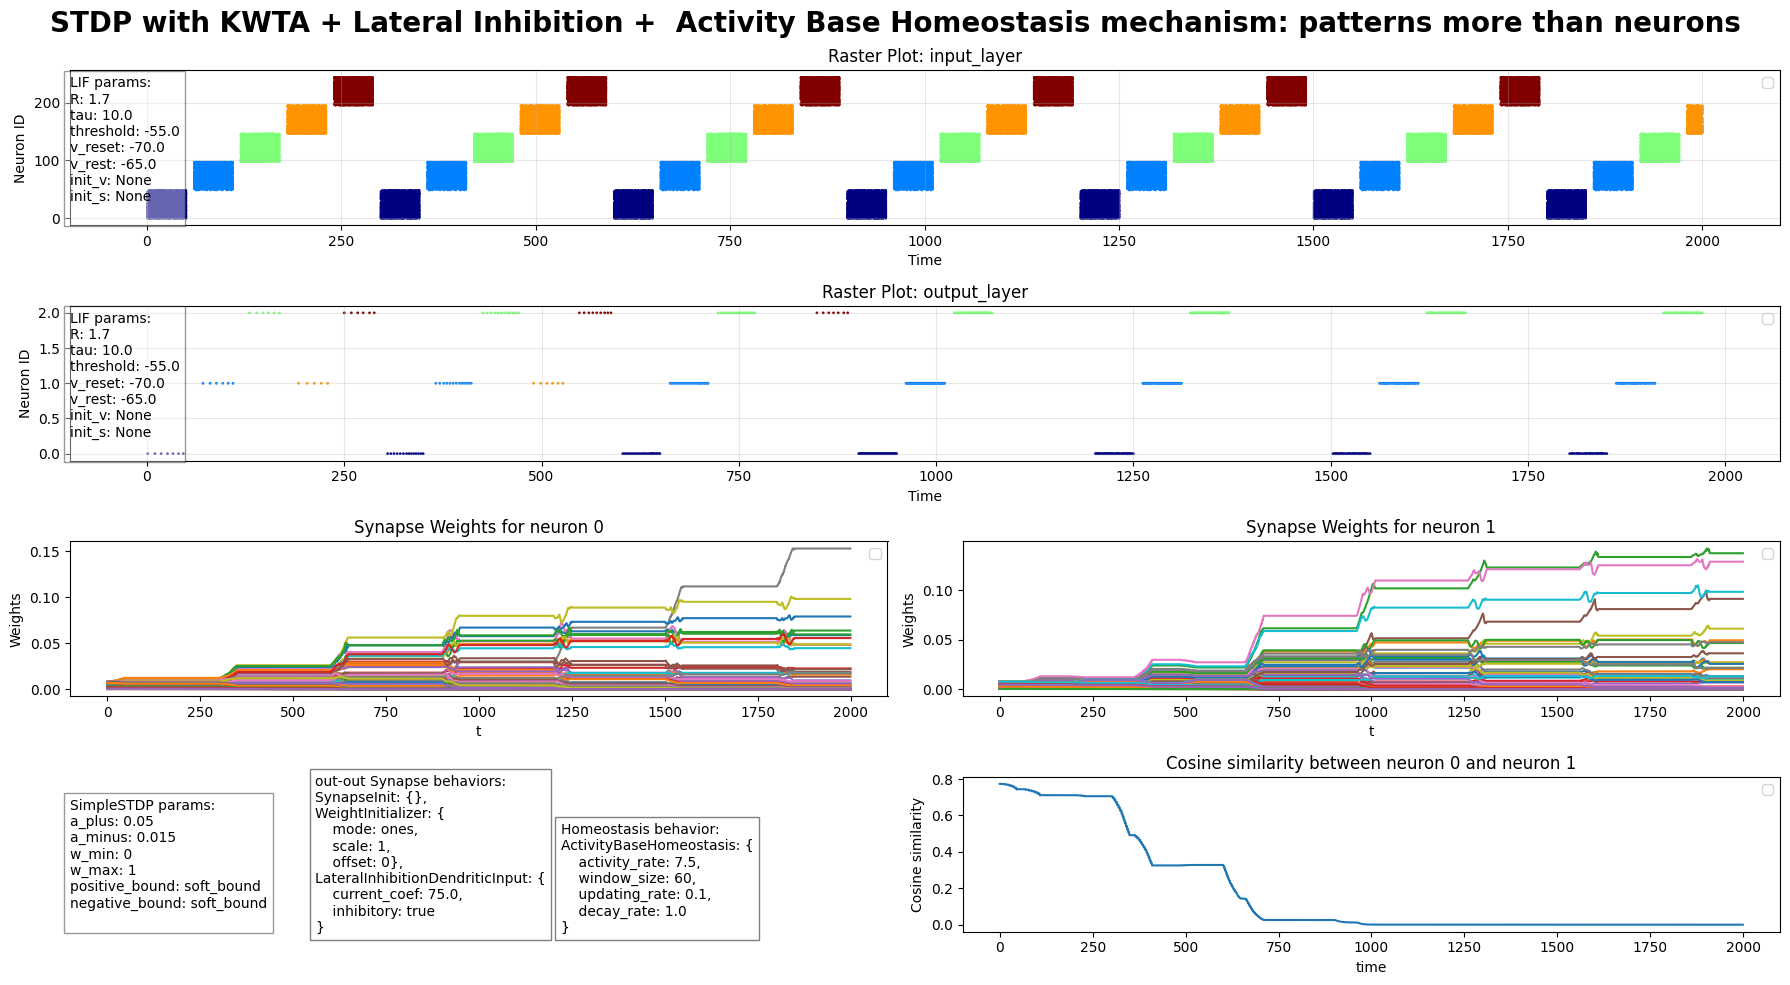

In [60]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("STDP with KWTA + Lateral Inhibition +  Activity Base Homeostasis mechanism: patterns more than neurons", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibtion-homeostasis-more-patterns.pdf")
plt.show()

### b) number of output neurons are more than patterns

In [61]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/5pic', resize_width=7, resize_height=7, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=2)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [75]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=7,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1),
            ActivityBaseHomeostasis(activity_rate=0.2*INSTANCE_DURATION,
                                    window_size=(INSTANCE_DURATION + SLEEP),
                                    updating_rate=0.1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.05,
                                        a_minus=0.015,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=75.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(252)|2 groups, Synapses: tensor(1764)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](245){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


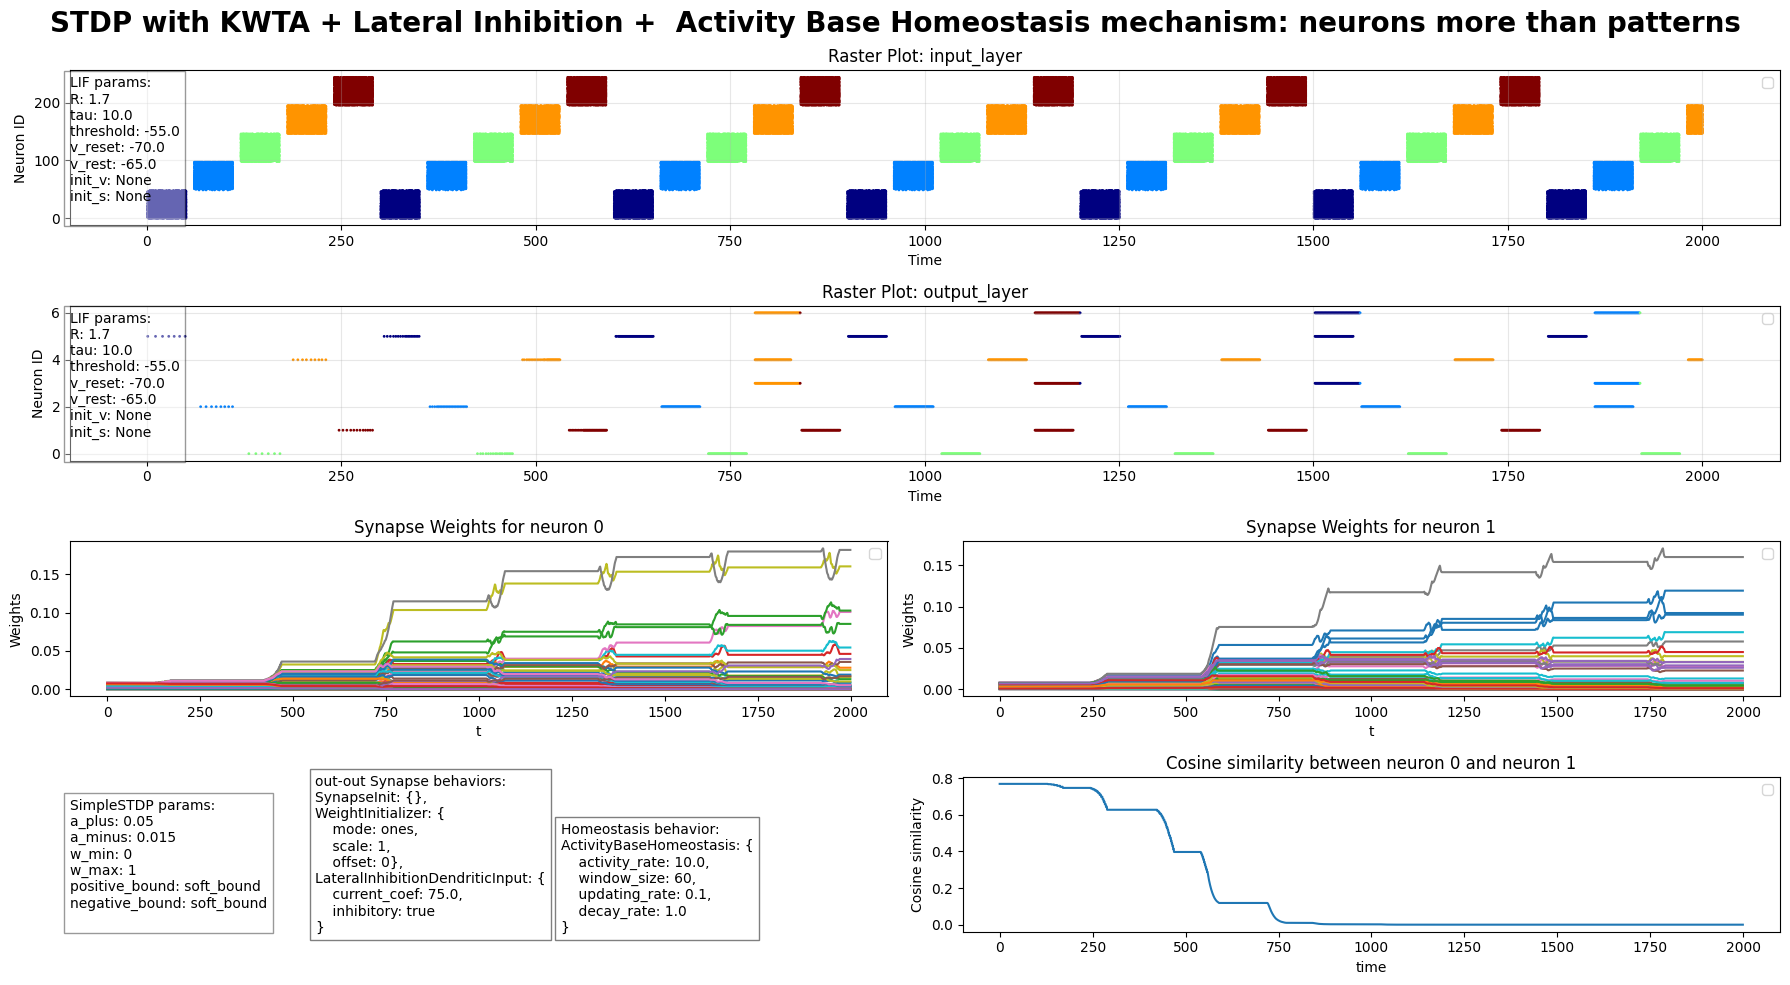

In [76]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in output_layer.behavior.items():
    if behavior.__class__.__name__ in ["ActivityBaseHomeostasis", "VoltageBaseHomeostasis"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
params_info = "Homeostasis behavior:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("STDP with KWTA + Lateral Inhibition +  Activity Base Homeostasis mechanism: neurons more than patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-simple-stdp-kwta-lateral-inhibtion-homeostasis-more-neurons.pdf")
plt.show()